# **English - Bengali:**

### **Library Installs:**

In [ ]:
pip install indic-nlp-library


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.7 MB/s eta 0:00:00


### **Imports:**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import spacy
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import math
from tqdm import tqdm
import csv
from torch.optim.lr_scheduler import ReduceLROnPlateau
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### **Data Loading from JSON files:**

In [ ]:
TRAIN_PATH = 'train_data1.json'
TEST_PATH = 'test_data1_final.json'

with open(TRAIN_PATH, 'r', encoding='utf-8') as file:
    data = json.load(file)

source_sentences_train = []
target_sentences_train = []

source_sentences_val = []
target_sentences_val = []

id_train = []
id_val = []

for language_pair, language_data in data.items():
    if(language_pair == "English-Bengali"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              target = entry_data["target"]
              if (data_type == "Validation"):
                source_sentences_val.append(source)
                target_sentences_val.append(target)
                id_val.append(entry_id)
              else:
                source_sentences_train.append(source)
                target_sentences_train.append(target)
                id_train.append(entry_id)

with open(TEST_PATH, 'r', encoding='utf-8') as file:
    data = json.load(file)

for language_pair, language_data in data.items():
    if(language_pair == "English-Bengali"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              if (data_type == "Test"):
                source_sentences_val.append(source)
                id_val.append(entry_id)

Language Pair: English-Bengali
  Data Type: Train
Language Pair: English-Bengali
  Data Type: Test


### **Data PreProcessing:**



**Reference:** https://doi.org/10.48550/arXiv.1409.3215

In this paper authors verified that reversing the source sentences while doing machine translation improved the results. I have taken this insight and used in my code.

> `"Finally, we found that reversing the order of the words in all source sentences (but not target sentences) improved the LSTM's performance markedly, because doing so introduced many short term dependencies between the source and the target sentence which made the optimization problem easier."`


**English Preprocessing:**
1. Sentences are converted to lowercase.
2. Each sentence is tokenized using spaCy, retaining only alphabetical tokens (removing punctuation and numbers).
3. The order of tokens is reversed in each sentence.

**Hindi Preprocessing:**
1. Sentences are normalized using the IndicNormalizer to handle inconsistencies like Unicode normalization.
2. Numbers and punctuation are removed.
3. Sentences are tokenized using a trivial tokenizer from Indic NLP library which is suitable for Indic languages.


In [ ]:
nlp = spacy.load("en_core_web_sm")

def preprocess_english(sentences):
    def preprocess_and_remove_punctuation(sentence):
        doc = nlp(sentence.lower())
        tokens = [token.text for token in doc if token.is_alpha]
        return tokens[::-1]
    tokenized_sentences = [preprocess_and_remove_punctuation(sentence) for sentence in sentences]
    return tokenized_sentences

def preprocess_bengali(sentences):
    normalizer = IndicNormalizerFactory().get_normalizer("bn")
    processed_sentences = []
    for sentence in sentences:
        normalized_sentence = normalizer.normalize(sentence)
        cleaned_sentence = ''.join([char for char in normalized_sentence if not char.isdigit() and char not in string.punctuation])
        tokens = list(indic_tokenize.trivial_tokenize(cleaned_sentence))
        processed_sentences.append(tokens)
    return processed_sentences


target_sentences_train = [re.sub(r'[a-zA-Z]', '', hi) for hi in target_sentences_train]

en_train = preprocess_english(source_sentences_train)
en_test = preprocess_english(source_sentences_val)
de_train = preprocess_bengali(target_sentences_train)
de_test = preprocess_bengali(target_sentences_val)

for i in range(10):
    print(en_train[i])
    print(de_train[i])
    print('\n')

['insouciance', 'into', 'serenity', 'and', 'calmness', 'its', 'interchanges', 'rocks', 'marble', 'the', 'through', 'flowing', 'narmada', 'the', 'where', 'point', 'the', 'visit', 'to', 'forget', 'not', 'do']
['এই', 'জায়গাগুলো', 'দেখতে', 'ভুলো', 'না', 'যেখানে', 'নর্মদা', 'নদী', 'মার্বেল', 'পাথরের', 'পাহাড়ের', 'মধ্য', 'দিয়ে', 'প্রবাহিত', 'হচ্ছে', 'এবং', 'নিজের', 'শান্তি', 'ও', 'সৌন্দর্যকে', 'অনাসক্তিতে', 'পরিণত', 'করছে', '।']


['illiteracy', 'is', 'poverty', 'of', 'cause', 'biggest', 'the', 'that', 'evident', 'is', 'it']
['এই', 'কথা', 'স্পষ্ট', 'যে', 'দরিদ্রতার', 'বড়', 'কারণ', 'হল', 'অশিক্ষা', '।']


['april', 'on', 'theatrically', 'released', 'was', 'film', 'the']
['চলচ্চিত্রটি', 'সালের', 'ই', 'এপ্রিল', 'প্রেক্ষাগৃহে', 'মুক্তি', 'পায়', '।']


['m', 'p', 'ten', 'at', 'party', 'birthday', 'wyatts', 'is']
['অনিমেষ', 'এর', 'জন্মদিনের', 'পার্টি', 'রাত', 'দশটায়']


['agriculture', 'and', 'industries', 'like', 'fields', 'other', 'many', 'in', 'used', 'also', 'is', 'barley', 'eatable', 'a

**Building Vocabulary:**

Created vocabularies for English and Hindi by collecting all unique tokens from the datasets and adds PAD, SOS, EOS. Then i generated mappings for word-to-index and index-to-word conversions which will be helpful during model training.

In [ ]:
en_index2word = ["<PAD>", "<SOS>", "<EOS>"]
de_index2word = ["<PAD>", "<SOS>", "<EOS>"]
en_vocab = set(en_index2word)
de_vocab = set(de_index2word)
for ds in [en_train, en_test]:
    for sent in ds:
        en_vocab.update(sent)
for ds in [de_train, de_test]:
    for sent in ds:
        de_vocab.update(sent)

en_index2word = list(en_vocab)
de_index2word = list(de_vocab)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
en_word2index = {token: idx for idx, token in enumerate(en_index2word)}
de_word2index = {token: idx for idx, token in enumerate(de_index2word)}

### **Data Analysis and Data Loading:**

**Sentence length distribution:** During model training we have to choose maximum sentence length, This plot helps us in understanding distribution of sentence lengths in the datasets. I have marked the 90th percentile as a reference. Based on the visualizations we can choose max sequence length as 30.

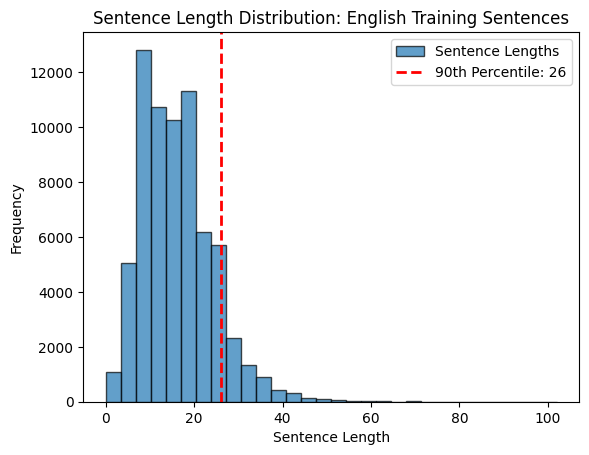

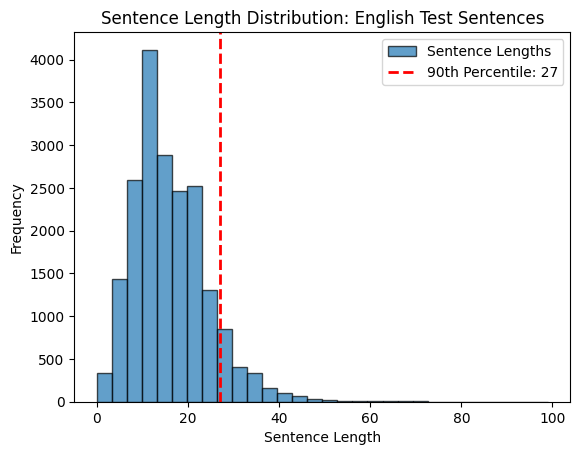

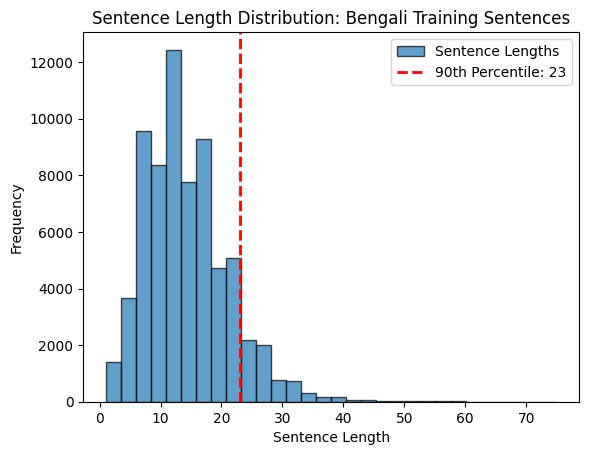

In [ ]:
def get_sentence_lengths(dataset):
    return [len(sentence) for sentence in dataset]

def plot_sentence_length_distribution_with_percentile(lengths, title):
    percentile_90 = np.percentile(lengths, 90)  # Calculate the 90th percentile
    plt.hist(lengths, bins=30, edgecolor='black', alpha=0.7, label="Sentence Lengths")
    plt.axvline(percentile_90, color='red', linestyle='dashed', linewidth=2, label=f"90th Percentile: {percentile_90:.0f}")
    plt.title(f"Sentence Length Distribution: {title}")
    plt.xlabel("Sentence Length")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

en_train_lengths = get_sentence_lengths(en_train)
en_test_lengths = get_sentence_lengths(en_test)
de_train_lengths = get_sentence_lengths(de_train)
de_test_lengths = get_sentence_lengths(de_test)

plot_sentence_length_distribution_with_percentile(en_train_lengths, "English Training Sentences")
plot_sentence_length_distribution_with_percentile(en_test_lengths, "English Test Sentences")
plot_sentence_length_distribution_with_percentile(de_train_lengths, "Bengali Training Sentences")


In [ ]:
def analyze_vocab(vocab, vocab_name):
    print(f"Total unique tokens: {len(vocab)}")
    print()

analyze_vocab(en_vocab, "English Vocabulary")
analyze_vocab(de_vocab, "Bengali Vocabulary")

Total unique tokens: 60963

Total unique tokens: 95334



In [ ]:
def print_sentence_stats(lengths, dataset_name):
    print(f"{dataset_name} Sentence Length Statistics")
    print(f"Min Length: {min(lengths)}")
    print(f"Max Length: {max(lengths)}")
    print(f"Mean Length: {np.mean(lengths):.2f}")
    print(f"Median Length: {np.median(lengths)}")
    print()

print_sentence_stats(en_train_lengths, "English Training")
print_sentence_stats(en_test_lengths, "English Test")
print_sentence_stats(de_train_lengths, "Bengali Training")

English Training Sentence Length Statistics
Min Length: 0
Max Length: 102
Mean Length: 15.98
Median Length: 15.0

English Test Sentence Length Statistics
Min Length: 0
Max Length: 99
Mean Length: 16.10
Median Length: 15.0

Bengali Training Sentence Length Statistics
Min Length: 1
Max Length: 75
Mean Length: 14.19
Median Length: 13.0



In [ ]:
max_seq_len = int(np.percentile([len(sent) for sent in en_train + de_train], 90))
print(f"90th percentile sentence length: {max_seq_len}")

90th percentile sentence length: 25


1. The pad_sequence function creates fixed-length sequences by adding SOS and EOS tokens, padding with PAD tokens, and truncating to max_len.

2. NMTDataset class processes source-target pairs into padded tensors for use in training.

3. DataLoaders batch the datasets for efficient training and validation.

In [ ]:
def pad_sequence(seq, vocab, max_len):
    padded_seq = [vocab["<SOS>"]] + [vocab.get(word, vocab["<PAD>"]) for word in seq[:max_len - 2]] + [vocab["<EOS>"]]
    padded_seq += [vocab["<PAD>"]] * (max_len - len(padded_seq))
    return padded_seq[:max_len]

class NMTDataset(Dataset):
    def __init__(self, source, target, source_vocab, target_vocab, max_len):
        self.source = [pad_sequence(sent, source_vocab, max_len) for sent in source]
        self.target = [pad_sequence(sent, target_vocab, max_len) for sent in target]

    def __len__(self):
        return len(self.source)

    def __getitem__(self, idx):
        return torch.tensor(self.source[idx]), torch.tensor(self.target[idx])

BATCH_SIZE = 64
MAX_SEQ_LEN = 30
train_src, val_src, train_tgt, val_tgt = train_test_split(en_train, de_train, test_size=0.1, random_state=42)
train_dataset = NMTDataset(train_src, train_tgt, en_word2index, de_word2index, MAX_SEQ_LEN)
val_dataset = NMTDataset(val_src, val_tgt, en_word2index, de_word2index, MAX_SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

### **Model Architecture:**

**Reference:** https://www.kaggle.com/datasets/thanakomsn/glove6b300dtxt

I have used glove embeddings of 300 dimensions present in this file.
These embeddings will be initial weights for the embedding layer, which will be updated during training .

In [ ]:
def load_glove_embeddings(file_path, vocab, embedding_dim):
    embeddings = np.random.uniform(-0.1, 0.1, (len(vocab), embedding_dim))
    embeddings[vocab["<PAD>"]] = np.zeros(embedding_dim)  # Ensure <PAD> is zeroed
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            if word in vocab:
                embeddings[vocab[word]] = vector
    return embeddings


glove_path = "glove.6B.300d.txt"
embedding_dim = 300
source_embeddings = load_glove_embeddings(glove_path, en_word2index, embedding_dim)
target_embeddings = load_glove_embeddings(glove_path, de_word2index, embedding_dim)


**Positional Embedding:** Next I created a class to create position-based embeddings for the data using sine and cosine to encode information about token positions. It calculates sine values for even positions and cosine values for odd positions in the embedding dimension. These embeddings are stored as a buffer and added to the input tensor during the forward pass. It ensures sequences up to a certain length get meaningful positional information for our Transformer model.

In [ ]:
class PositionalEncodingSinusoidal(nn.Module):
    def __init__(self, embedding_dimension, maximum_sequence_length):
        super(PositionalEncodingSinusoidal, self).__init__()
        positions = torch.arange(0, maximum_sequence_length).unsqueeze(1).float()
        division_term = torch.exp(torch.arange(0, embedding_dimension, 2).float() * -(math.log(10000.0) / embedding_dimension))
        positional_embeddings = torch.zeros(maximum_sequence_length, embedding_dimension)
        positional_embeddings[:, 0::2] = torch.sin(positions * division_term) #Use sine for even indices (0, 2, 4, ...)
        positional_embeddings[:, 1::2] = torch.cos(positions * division_term) #Using cosine for odd indices (1, 3, 5, ...).
        self.register_buffer('positional_embeddings', positional_embeddings)

    def forward(self, input_tensor):
        sequence_length = input_tensor.size(1)
        return input_tensor + self.positional_embeddings[:sequence_length, :].unsqueeze(0).to(input_tensor.device)



NeuralTransformer class Initializes source and target embeddings with glove embeddings and adds sinusoidal positional encodings. Then i have built transformer model using PyTorch's nn.Transformer. This code processes input sequences through embeddings, adds positional encodings, and the transformer module with attention masks.Finally it outputs predictions by applying a linear layer to the transformer's output for the target vocabulary.

**Reference:** https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

In [ ]:
class NeuralTransformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, embedding_dimension, attention_heads, encoder_layers, decoder_layers, dropout_rate, maximum_sequence_length, source_embeddings=None, target_embeddings=None):
        super(NeuralTransformer, self).__init__()

        # Initialize source and target embeddings
        self.source_embedding = nn.Embedding(source_vocab_size, embedding_dimension)
        self.target_embedding = nn.Embedding(target_vocab_size, embedding_dimension)

        if source_embeddings is not None:
            self.source_embedding.weight.data.copy_(torch.tensor(source_embeddings))
            self.source_embedding.weight.requires_grad = True

        if target_embeddings is not None:
            self.target_embedding.weight.data.copy_(torch.tensor(target_embeddings))
            self.target_embedding.weight.requires_grad = True

        self.positional_encoding = PositionalEncodingSinusoidal(embedding_dimension, maximum_sequence_length)

        self.transformer_core = nn.Transformer(
            d_model=embedding_dimension,
            nhead=attention_heads,
            num_encoder_layers=encoder_layers,
            num_decoder_layers=decoder_layers,
            dropout=dropout_rate,
            batch_first=True
        )
        self.output_layer = nn.Linear(embedding_dimension, target_vocab_size)

    def forward(self, source_sequence, target_sequence):
        embedded_source = self.positional_encoding(self.source_embedding(source_sequence))
        embedded_target = self.positional_encoding(self.target_embedding(target_sequence))
        source_mask = self.transformer_core.generate_square_subsequent_mask(source_sequence.size(1)).to(device)
        target_mask = self.transformer_core.generate_square_subsequent_mask(target_sequence.size(1)).to(device)
        transformer_output = self.transformer_core(embedded_source, embedded_target, src_mask=source_mask, tgt_mask=target_mask)
        return self.output_layer(transformer_output)


### **Training and Evaluating the model:**

sentence_translation translates source sentences into target sentences by using a trained model. It tokenises given input sentence and does all the necessary pre-processing like padding or truncation of the sentence and then iteratively generates tokens in the target language by feeding in the source tensor and the latest predicted target tokens into the model until the end-of-sequence token (<EOS>) is reached or the maximum length is exceeded.

In [ ]:
def sentence_translation(input_sentence, trained_model, source_vocabulary, target_vocabulary, maximum_length):
    trained_model.eval()
    tokenized_input = pad_sequence(input_sentence, source_vocabulary, maximum_length)
    source_tensor = torch.tensor(tokenized_input).unsqueeze(0).to(device)
    target_tokens = [target_vocabulary["<SOS>"]]
    for _ in range(maximum_length):
        target_tensor = torch.tensor(target_tokens).unsqueeze(0).to(device)
        with torch.no_grad():
            predicted_output = trained_model(source_tensor, target_tensor)
        next_predicted_token = predicted_output.argmax(2)[:, -1].item()
        target_tokens.append(next_predicted_token)
        if next_predicted_token == target_vocabulary["<EOS>"]:
            break
    return [list(target_vocabulary.keys())[tok] for tok in target_tokens[1:-1]]


This function will calculate the performance of a trained model on a validation dataset. The function processes batches of data from validation_loader. On every batch, it uses the model to make predictions, then calculates the loss using a provided loss_function and finds the total validation loss.

In [ ]:
def validate_model(trained_model, validation_loader, loss_function):
    trained_model.eval()
    cumulative_validation_loss = 0
    with torch.no_grad():
        for source_batch, target_batch in validation_loader:
            source_batch, target_batch = source_batch.to(device), target_batch.to(device)
            target_input_sequence = target_batch[:, :-1]
            target_expected_sequence = target_batch[:, 1:]
            with torch.cuda.amp.autocast():
                model_predictions = trained_model(source_batch, target_input_sequence)
                reshaped_predictions = model_predictions.reshape(-1, model_predictions.shape[-1])
                reshaped_targets = target_expected_sequence.reshape(-1)
                loss_per_batch = loss_function(reshaped_predictions, reshaped_targets)
            cumulative_validation_loss += loss_per_batch.item()
    return cumulative_validation_loss / len(validation_loader)

1. This function trains a Transformer-based model using mixed precision for efficiency on a GPU. (**Reference for mixed precision**:https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html )

2. Loss computation against target sequences will be performed using the given loss criterion. The estimated loss is backpropagated, and the parameters will be updated using the optimizer.

3. After every epoch there is a scheduler which based on the performance of the model on the validation set changes the learning rate.

4. If this is the best observed validation loss the model checkpoint will be saved, storing information above model state along with optimizer, scheduler, and scaler details.

5. Training will be stopped if the validation loss does not improve throughout three consecutive epochs to prevent overfitting .

In [ ]:

def train_transformer_model(model,training_data_loader,validation_data_loader,optimizer,scheduler,loss_criterion,num_epochs, device,source_vocab, target_vocab, max_sequence_length,save_path="best_model.pth"):
    scaler = torch.cuda.amp.GradScaler()
    best_validation_loss = float('inf')  # Keeps track of the best validation loss
    no_improvement_epochs = 0  # Counter for consecutive epochs without improvement

    for epoch in range(num_epochs):
        model.train()
        total_training_loss = 0
        progress_bar = tqdm(enumerate(training_data_loader),total=len(training_data_loader),desc=f"Epoch {epoch + 1}/{num_epochs}",unit="batch" )
        for batch_index, (source_batch, target_batch) in progress_bar:
            source_batch, target_batch = source_batch.to(device), target_batch.to(device)
            target_inputs = target_batch[:, :-1]
            target_outputs = target_batch[:, 1:]
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                model_predictions = model(source_batch, target_inputs)
                reshaped_predictions = model_predictions.reshape(-1, model_predictions.shape[-1])
                reshaped_targets = target_outputs.reshape(-1)
                batch_loss = loss_criterion(reshaped_predictions, reshaped_targets)
            scaler.scale(batch_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_training_loss += batch_loss.item()
            progress_bar.set_postfix(loss=batch_loss.item())
            if batch_index % 100 == 0:
                test_sentence = ["hello", "brother", "how", "are", "you"]
                translated_sentence = sentence_translation(
                    test_sentence, model, source_vocab, target_vocab, max_sequence_length
                )
                print(f"Batch {batch_index} Translation: {' '.join(test_sentence)} -> {' '.join(translated_sentence)}")
        average_training_loss = total_training_loss / len(training_data_loader)
        print(f"Epoch {epoch + 1} Training Loss: {average_training_loss:.4f}")
        validation_loss = validate_model(model, validation_data_loader, loss_criterion)
        print(f"Epoch {epoch + 1} Validation Loss: {validation_loss:.4f}")
        scheduler.step(validation_loss)

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            no_improvement_epochs = 0  # Reset counter

            # Save the model checkpoint
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_validation_loss': best_validation_loss,
                'scaler_state_dict': scaler.state_dict()
            }, save_path)
            print(f"Model checkpoint saved at epoch {epoch + 1} with validation loss {validation_loss:.4f}.")
        else:
            no_improvement_epochs += 1  # Increment counter

        # Early stopping condition
        if no_improvement_epochs >= 3:
            print(f"Early stopping triggered after {no_improvement_epochs} consecutive epochs without improvement.")
            break

    print("Training complete.")


Initializing the model by passing hyperparameters and starting the training pipeline:

In [ ]:
BATCH_SIZE = 64
EMBED_DIM = 300
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
DROPOUT = 0.3
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralTransformer(
    source_vocab_size=len(en_word2index),target_vocab_size=len(de_word2index),embedding_dimension=embedding_dim, attention_heads=6,encoder_layers=6,
    decoder_layers=6,dropout_rate=0.1,maximum_sequence_length=MAX_SEQ_LEN,source_embeddings=source_embeddings, target_embeddings=target_embeddings
).to(device)


criterion = nn.CrossEntropyLoss(ignore_index=de_word2index["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

train_transformer_model(
    model=model,
    training_data_loader=train_loader,
    validation_data_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_criterion=criterion,
    num_epochs=NUM_EPOCHS,
    device=device,
    source_vocab=en_word2index,
    target_vocab=de_word2index,
    max_sequence_length=MAX_SEQ_LEN,
    save_path="best_model.pth"
)

random_sentence = en_test[0]
translated_sentence = sentence_translation(random_sentence, model, en_word2index, de_word2index, MAX_SEQ_LEN)
print(f"Source: {' '.join(random_sentence)}")
print(f"Translation: {' '.join(translated_sentence)}")

<ipython-input-12-46f60dfd13de>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50:   0%|          | 0/969 [00:00<?, ?batch/s]<ipython-input-12-46f60dfd13de>:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50:   0%|          | 2/969 [00:01<13:08,  1.23batch/s, loss=11.3]

Batch 0 Translation: hello brother how are you -> 


Epoch 1/50:  11%|█         | 102/969 [00:14<01:48,  7.99batch/s, loss=8.57]

Batch 100 Translation: hello brother how are you -> 


Epoch 1/50:  21%|██        | 202/969 [00:27<01:57,  6.51batch/s, loss=8.17]

Batch 200 Translation: hello brother how are you -> এই


Epoch 1/50:  31%|███       | 302/969 [00:40<01:37,  6.86batch/s, loss=7.89]

Batch 300 Translation: hello brother how are you -> এই


Epoch 1/50:  41%|████▏     | 402/969 [00:53<01:16,  7.40batch/s, loss=7.84]

Batch 400 Translation: hello brother how are you -> আমার কি


Epoch 1/50:  52%|█████▏    | 502/969 [01:07<01:06,  7.07batch/s, loss=7.71]

Batch 500 Translation: hello brother how are you -> আমার আমার কি কি


Epoch 1/50:  62%|██████▏   | 602/969 [01:20<00:51,  7.17batch/s, loss=7.79]

Batch 600 Translation: hello brother how are you -> আমার কি কি


Epoch 1/50:  72%|███████▏  | 702/969 [01:33<00:43,  6.15batch/s, loss=7.63]

Batch 700 Translation: hello brother how are you -> আমার কি কি


Epoch 1/50:  83%|████████▎ | 802/969 [01:47<00:25,  6.45batch/s, loss=7.61]

Batch 800 Translation: hello brother how are you -> আমার কি কি


Epoch 1/50:  93%|█████████▎| 902/969 [02:00<00:09,  7.06batch/s, loss=7.47]

Batch 900 Translation: hello brother how are you -> আমার কি কি কি


Epoch 1/50: 100%|██████████| 969/969 [02:09<00:00,  7.48batch/s, loss=8.05]
<ipython-input-12-46f60dfd13de>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Training Loss: 8.0142
Epoch 1 Validation Loss: 7.5080
Model checkpoint saved at epoch 1 with validation loss 7.5080.


Epoch 2/50:   0%|          | 2/969 [00:00<02:56,  5.47batch/s, loss=7.37]

Batch 0 Translation: hello brother how are you -> আমার কি কি কি


Epoch 2/50:  11%|█         | 102/969 [00:13<01:59,  7.24batch/s, loss=7.35]

Batch 100 Translation: hello brother how are you -> আপনি কি কি


Epoch 2/50:  21%|██        | 202/969 [00:27<01:50,  6.93batch/s, loss=7.24]

Batch 200 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 2/50:  31%|███       | 302/969 [00:40<01:49,  6.07batch/s, loss=7.32]

Batch 300 Translation: hello brother how are you -> আপনি কি কি


Epoch 2/50:  41%|████▏     | 402/969 [00:53<01:28,  6.37batch/s, loss=7.23]

Batch 400 Translation: hello brother how are you -> আপনি কি কি


Epoch 2/50:  52%|█████▏    | 502/969 [01:07<01:04,  7.24batch/s, loss=7.24]

Batch 500 Translation: hello brother how are you -> আপনি কি কি


Epoch 2/50:  62%|██████▏   | 602/969 [01:20<00:50,  7.29batch/s, loss=7]

Batch 600 Translation: hello brother how are you -> আপনি কি কি


Epoch 2/50:  72%|███████▏  | 702/969 [01:34<00:36,  7.26batch/s, loss=7.11]

Batch 700 Translation: hello brother how are you -> আপনি কি কি


Epoch 2/50:  83%|████████▎ | 802/969 [01:47<00:27,  6.09batch/s, loss=6.94]

Batch 800 Translation: hello brother how are you -> আপনি কি আপনি কি


Epoch 2/50:  93%|█████████▎| 902/969 [02:00<00:11,  6.07batch/s, loss=6.84]

Batch 900 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 2/50: 100%|██████████| 969/969 [02:09<00:00,  7.47batch/s, loss=6.96]


Epoch 2 Training Loss: 7.1261
Epoch 2 Validation Loss: 7.0048
Model checkpoint saved at epoch 2 with validation loss 7.0048.


Epoch 3/50:   0%|          | 2/969 [00:00<02:55,  5.50batch/s, loss=6.55]

Batch 0 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 3/50:  11%|█         | 102/969 [00:13<02:01,  7.11batch/s, loss=6.88]

Batch 100 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 3/50:  21%|██        | 202/969 [00:27<02:08,  5.98batch/s, loss=6.82]

Batch 200 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 3/50:  31%|███       | 302/969 [00:40<01:46,  6.24batch/s, loss=6.55]

Batch 300 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 3/50:  41%|████▏     | 402/969 [00:53<01:20,  7.05batch/s, loss=6.47]

Batch 400 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 3/50:  52%|█████▏    | 502/969 [01:07<01:04,  7.27batch/s, loss=6.76]

Batch 500 Translation: hello brother how are you -> আপনি কি কি


Epoch 3/50:  62%|██████▏   | 602/969 [01:20<00:51,  7.09batch/s, loss=6.84]

Batch 600 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 3/50:  72%|███████▏  | 702/969 [01:33<00:44,  6.02batch/s, loss=6.72]

Batch 700 Translation: hello brother how are you -> আপনি কি যে কি


Epoch 3/50:  83%|████████▎ | 802/969 [01:47<00:25,  6.45batch/s, loss=6.38]

Batch 800 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 3/50:  93%|█████████▎| 902/969 [02:00<00:09,  7.14batch/s, loss=6.53]

Batch 900 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 3/50: 100%|██████████| 969/969 [02:09<00:00,  7.49batch/s, loss=6.16]


Epoch 3 Training Loss: 6.6048
Epoch 3 Validation Loss: 6.6285
Model checkpoint saved at epoch 3 with validation loss 6.6285.


Epoch 4/50:   0%|          | 2/969 [00:00<03:18,  4.87batch/s, loss=6.49]

Batch 0 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 4/50:  11%|█         | 102/969 [00:13<01:59,  7.23batch/s, loss=6.38]

Batch 100 Translation: hello brother how are you -> আপনি কি কি কি


Epoch 4/50:  21%|██        | 202/969 [00:26<01:46,  7.21batch/s, loss=6.12]

Batch 200 Translation: hello brother how are you -> আপনি কি কি


Epoch 4/50:  31%|███       | 302/969 [00:40<01:33,  7.12batch/s, loss=6.12]

Batch 300 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 4/50:  41%|████▏     | 402/969 [00:53<01:21,  6.93batch/s, loss=6.14]

Batch 400 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 4/50:  52%|█████▏    | 502/969 [01:06<01:17,  6.02batch/s, loss=6.28]

Batch 500 Translation: hello brother how are you -> আপনি কি বলুন বলুন


Epoch 4/50:  62%|██████▏   | 602/969 [01:19<00:54,  6.71batch/s, loss=6.37]

Batch 600 Translation: hello brother how are you -> আপনি কি কি


Epoch 4/50:  72%|███████▏  | 702/969 [01:33<00:37,  7.09batch/s, loss=6.44]

Batch 700 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 4/50:  83%|████████▎ | 802/969 [01:46<00:22,  7.31batch/s, loss=6.23]

Batch 800 Translation: hello brother how are you -> আপনি কি কি


Epoch 4/50:  93%|█████████▎| 902/969 [01:59<00:09,  7.04batch/s, loss=5.82]

Batch 900 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 4/50: 100%|██████████| 969/969 [02:08<00:00,  7.56batch/s, loss=6.17]


Epoch 4 Training Loss: 6.1786
Epoch 4 Validation Loss: 6.3428
Model checkpoint saved at epoch 4 with validation loss 6.3428.


Epoch 5/50:   0%|          | 2/969 [00:00<02:50,  5.68batch/s, loss=5.85]

Batch 0 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 5/50:  11%|█         | 102/969 [00:13<02:01,  7.16batch/s, loss=5.69]

Batch 100 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 5/50:  21%|██        | 202/969 [00:27<02:07,  6.03batch/s, loss=5.5]

Batch 200 Translation: hello brother how are you -> আপনি কি আমাকে কি


Epoch 5/50:  31%|███       | 302/969 [00:40<01:46,  6.25batch/s, loss=5.72]

Batch 300 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 5/50:  41%|████▏     | 402/969 [00:53<01:20,  7.01batch/s, loss=5.85]

Batch 400 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 5/50:  52%|█████▏    | 502/969 [01:06<01:04,  7.20batch/s, loss=5.56]

Batch 500 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 5/50:  62%|██████▏   | 602/969 [01:20<00:50,  7.25batch/s, loss=5.86]

Batch 600 Translation: hello brother how are you -> আপনি কি আমার বলুন


Epoch 5/50:  72%|███████▏  | 702/969 [01:33<00:41,  6.45batch/s, loss=5.96]

Batch 700 Translation: hello brother how are you -> আপনি কি আমার বলুন


Epoch 5/50:  83%|████████▎ | 802/969 [01:46<00:26,  6.26batch/s, loss=5.47]

Batch 800 Translation: hello brother how are you -> আপনি কি বলুন


Epoch 5/50:  93%|█████████▎| 902/969 [01:59<00:09,  7.13batch/s, loss=5.57]

Batch 900 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 5/50: 100%|██████████| 969/969 [02:08<00:00,  7.51batch/s, loss=5.68]


Epoch 5 Training Loss: 5.7981
Epoch 5 Validation Loss: 6.1291
Model checkpoint saved at epoch 5 with validation loss 6.1291.


Epoch 6/50:   0%|          | 2/969 [00:00<02:59,  5.37batch/s, loss=5.69]

Batch 0 Translation: hello brother how are you -> আপনি কি আমার কি


Epoch 6/50:  11%|█         | 102/969 [00:13<02:17,  6.29batch/s, loss=5.52]

Batch 100 Translation: hello brother how are you -> আপনি কি আমার বলুন


Epoch 6/50:  21%|██        | 202/969 [00:26<01:47,  7.12batch/s, loss=5.47]

Batch 200 Translation: hello brother how are you -> আপনি কি আমাকে বলুন


Epoch 6/50:  31%|███       | 302/969 [00:40<01:37,  6.87batch/s, loss=5.56]

Batch 300 Translation: hello brother how are you -> আপনি কি আমার বলুন


Epoch 6/50:  41%|████▏     | 402/969 [00:53<01:17,  7.27batch/s, loss=5.49]

Batch 400 Translation: hello brother how are you -> আপনি কি বলুন


Epoch 6/50:  52%|█████▏    | 502/969 [01:07<01:12,  6.47batch/s, loss=5.56]

Batch 500 Translation: hello brother how are you -> আপনি কি আমার বলুন


Epoch 6/50:  62%|██████▏   | 602/969 [01:19<00:57,  6.39batch/s, loss=5.37]

Batch 600 Translation: hello brother how are you -> আপনি কি বলুন


Epoch 6/50:  72%|███████▏  | 702/969 [01:33<00:37,  7.08batch/s, loss=5.61]

Batch 700 Translation: hello brother how are you -> আপনি কি আমার বলুন


Epoch 6/50:  83%|████████▎ | 802/969 [01:46<00:23,  7.20batch/s, loss=5.55]

Batch 800 Translation: hello brother how are you -> আপনি কি আমাকে কি


Epoch 6/50:  93%|█████████▎| 902/969 [01:59<00:09,  7.19batch/s, loss=5.67]

Batch 900 Translation: hello brother how are you -> আপনি কি আমাকে জানতে


Epoch 6/50: 100%|██████████| 969/969 [02:08<00:00,  7.54batch/s, loss=5.52]


Epoch 6 Training Loss: 5.4406
Epoch 6 Validation Loss: 5.9458
Model checkpoint saved at epoch 6 with validation loss 5.9458.


Epoch 7/50:   0%|          | 2/969 [00:00<03:03,  5.27batch/s, loss=5.32]

Batch 0 Translation: hello brother how are you -> আপনি কি আমার ভাই


Epoch 7/50:  11%|█         | 102/969 [00:13<02:01,  7.14batch/s, loss=5.34]

Batch 100 Translation: hello brother how are you -> আপনি কি আমাকে বলুন


Epoch 7/50:  21%|██        | 202/969 [00:27<01:47,  7.13batch/s, loss=5.06]

Batch 200 Translation: hello brother how are you -> আপনি কি আমাকে বলুন


Epoch 7/50:  31%|███       | 302/969 [00:40<01:50,  6.02batch/s, loss=5.17]

Batch 300 Translation: hello brother how are you -> আপনি কি আমার ভাই


Epoch 7/50:  41%|████▏     | 402/969 [00:53<01:32,  6.11batch/s, loss=5.37]

Batch 400 Translation: hello brother how are you -> আপনি কি আমাকে বলুন


Epoch 7/50:  52%|█████▏    | 502/969 [01:07<01:05,  7.10batch/s, loss=5.08]

Batch 500 Translation: hello brother how are you -> আপনি কি বন্ধু বলুন


Epoch 7/50:  62%|██████▏   | 602/969 [01:20<00:51,  7.08batch/s, loss=5.18]

Batch 600 Translation: hello brother how are you -> আপনি কি বন্ধু বলুন


Epoch 7/50:  72%|███████▏  | 702/969 [01:34<00:37,  7.03batch/s, loss=5.19]

Batch 700 Translation: hello brother how are you -> আপনি কি জানতে


Epoch 7/50:  83%|████████▎ | 802/969 [01:47<00:27,  6.00batch/s, loss=5.24]

Batch 800 Translation: hello brother how are you -> আপনি কি বন্ধু বন্ধু


Epoch 7/50:  93%|█████████▎| 902/969 [02:01<00:10,  6.31batch/s, loss=5.06]

Batch 900 Translation: hello brother how are you -> আপনি কি বন্ধু


Epoch 7/50: 100%|██████████| 969/969 [02:10<00:00,  7.44batch/s, loss=5.27]


Epoch 7 Training Loss: 5.0942
Epoch 7 Validation Loss: 5.7673
Model checkpoint saved at epoch 7 with validation loss 5.7673.


Epoch 8/50:   0%|          | 2/969 [00:00<03:00,  5.37batch/s, loss=4.78]

Batch 0 Translation: hello brother how are you -> আপনি কি বন্ধু কত


Epoch 8/50:  11%|█         | 102/969 [00:13<02:06,  6.86batch/s, loss=4.66]

Batch 100 Translation: hello brother how are you -> আপনি কি আমাকে কেমন


Epoch 8/50:  21%|██        | 202/969 [00:27<02:06,  6.05batch/s, loss=4.72]

Batch 200 Translation: hello brother how are you -> আপনি কি আমাকে বন্ধু


Epoch 8/50:  31%|███       | 302/969 [00:40<01:42,  6.49batch/s, loss=4.56]

Batch 300 Translation: hello brother how are you -> আপনি কি আমাকে বলুন


Epoch 8/50:  41%|████▏     | 402/969 [00:54<01:20,  7.07batch/s, loss=4.66]

Batch 400 Translation: hello brother how are you -> আপনি কি বলুন


Epoch 8/50:  52%|█████▏    | 502/969 [01:08<01:08,  6.80batch/s, loss=4.66]

Batch 500 Translation: hello brother how are you -> আপনি কি বন্ধু কত


Epoch 8/50:  62%|██████▏   | 602/969 [01:21<00:51,  7.14batch/s, loss=4.68]

Batch 600 Translation: hello brother how are you -> আপনি কি বন্ধু


Epoch 8/50:  72%|███████▏  | 702/969 [01:34<00:41,  6.43batch/s, loss=4.6]

Batch 700 Translation: hello brother how are you -> আপনি কি ভাই


Epoch 8/50:  83%|████████▎ | 802/969 [01:48<00:25,  6.50batch/s, loss=4.99]

Batch 800 Translation: hello brother how are you -> আপনি কি বন্ধু


Epoch 8/50:  93%|█████████▎| 902/969 [02:01<00:09,  7.06batch/s, loss=4.44]

Batch 900 Translation: hello brother how are you -> আপনি কি বন্ধু বলুন


Epoch 8/50: 100%|██████████| 969/969 [02:11<00:00,  7.39batch/s, loss=4.95]


Epoch 8 Training Loss: 4.7569
Epoch 8 Validation Loss: 5.6579
Model checkpoint saved at epoch 8 with validation loss 5.6579.


Epoch 9/50:   0%|          | 2/969 [00:00<03:20,  4.81batch/s, loss=4.46]

Batch 0 Translation: hello brother how are you -> আপনি কি বন্ধু কত


Epoch 9/50:  11%|█         | 102/969 [00:13<02:16,  6.35batch/s, loss=4.59]

Batch 100 Translation: hello brother how are you -> আপনি কি বন্ধু বলুন


Epoch 9/50:  21%|██        | 202/969 [00:27<01:47,  7.14batch/s, loss=4.61]

Batch 200 Translation: hello brother how are you -> আপনি কি বন্ধু


Epoch 9/50:  31%|███       | 302/969 [00:41<01:36,  6.94batch/s, loss=4.41]

Batch 300 Translation: hello brother how are you -> আপনি কি বন্ধু বন্ধু


Epoch 9/50:  41%|████▏     | 402/969 [00:54<01:20,  7.02batch/s, loss=4.59]

Batch 400 Translation: hello brother how are you -> আপনি কি বন্ধু


Epoch 9/50:  52%|█████▏    | 502/969 [01:08<01:14,  6.27batch/s, loss=4.48]

Batch 500 Translation: hello brother how are you -> আপনি কি বন্ধু বন্ধু


Epoch 9/50:  62%|██████▏   | 602/969 [01:21<00:56,  6.53batch/s, loss=4.46]

Batch 600 Translation: hello brother how are you -> আপনি কি বন্ধু বন্ধু


Epoch 9/50:  72%|███████▏  | 702/969 [01:34<00:37,  7.07batch/s, loss=4.58]

Batch 700 Translation: hello brother how are you -> আপনি কি বন্ধু কতটা


Epoch 9/50:  83%|████████▎ | 802/969 [01:48<00:24,  6.95batch/s, loss=4.7]

Batch 800 Translation: hello brother how are you -> আপনি কি বন্ধু কত


Epoch 9/50:  93%|█████████▎| 902/969 [02:02<00:10,  6.70batch/s, loss=4.85]

Batch 900 Translation: hello brother how are you -> আপনি কি বন্ধু কত


Epoch 9/50: 100%|██████████| 969/969 [02:10<00:00,  7.41batch/s, loss=4.88]


Epoch 9 Training Loss: 4.4239
Epoch 9 Validation Loss: 5.5571
Model checkpoint saved at epoch 9 with validation loss 5.5571.


Epoch 10/50:   0%|          | 2/969 [00:00<02:50,  5.68batch/s, loss=3.98]

Batch 0 Translation: hello brother how are you -> আপনি কি কতটা


Epoch 10/50:  11%|█         | 102/969 [00:13<02:06,  6.83batch/s, loss=4.15]

Batch 100 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 10/50:  21%|██        | 202/969 [00:27<02:13,  5.77batch/s, loss=4]

Batch 200 Translation: hello brother how are you -> আপনি কি বন্ধু বন্ধু


Epoch 10/50:  31%|███       | 302/969 [00:40<01:45,  6.31batch/s, loss=3.94]

Batch 300 Translation: hello brother how are you -> আপনি কি বন্ধু কতটা


Epoch 10/50:  41%|████▏     | 402/969 [00:54<01:21,  7.00batch/s, loss=4.26]

Batch 400 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 10/50:  52%|█████▏    | 502/969 [01:08<01:06,  6.98batch/s, loss=3.8]

Batch 500 Translation: hello brother how are you -> আপনি কি ভাই


Epoch 10/50:  62%|██████▏   | 602/969 [01:21<00:52,  7.04batch/s, loss=3.86]

Batch 600 Translation: hello brother how are you -> আপনি কি বন্ধু নাম


Epoch 10/50:  72%|███████▏  | 702/969 [01:35<00:47,  5.65batch/s, loss=3.75]

Batch 700 Translation: hello brother how are you -> আপনি কি বন্ধু কত


Epoch 10/50:  83%|████████▎ | 802/969 [01:48<00:26,  6.23batch/s, loss=4.02]

Batch 800 Translation: hello brother how are you -> আপনি কি বন্ধু বন্ধু


Epoch 10/50:  93%|█████████▎| 902/969 [02:02<00:09,  6.91batch/s, loss=4.06]

Batch 900 Translation: hello brother how are you -> আপনি কি ভাই


Epoch 10/50: 100%|██████████| 969/969 [02:11<00:00,  7.37batch/s, loss=4.19]


Epoch 10 Training Loss: 4.0927
Epoch 10 Validation Loss: 5.5038
Model checkpoint saved at epoch 10 with validation loss 5.5038.


Epoch 11/50:   0%|          | 2/969 [00:00<03:24,  4.72batch/s, loss=3.83]

Batch 0 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 11/50:  11%|█         | 102/969 [00:13<02:19,  6.24batch/s, loss=3.61]

Batch 100 Translation: hello brother how are you -> আপনি কি ভাই কত


Epoch 11/50:  21%|██        | 202/969 [00:27<01:51,  6.89batch/s, loss=3.94]

Batch 200 Translation: hello brother how are you -> আপনি কি বন্ধু বন্ধু


Epoch 11/50:  31%|███       | 302/969 [00:41<01:35,  7.00batch/s, loss=3.88]

Batch 300 Translation: hello brother how are you -> আপনি কি বন্ধু কত


Epoch 11/50:  41%|████▏     | 402/969 [00:54<01:23,  6.82batch/s, loss=3.55]

Batch 400 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 11/50:  52%|█████▏    | 502/969 [01:08<01:14,  6.23batch/s, loss=3.83]

Batch 500 Translation: hello brother how are you -> আপনি কি ভাই কিভাবে


Epoch 11/50:  62%|██████▏   | 602/969 [01:21<00:57,  6.35batch/s, loss=3.62]

Batch 600 Translation: hello brother how are you -> আপনি কি বন্ধু কতটা


Epoch 11/50:  72%|███████▏  | 702/969 [01:34<00:38,  6.96batch/s, loss=3.8]

Batch 700 Translation: hello brother how are you -> আপনি কি ভাই কতটা


Epoch 11/50:  83%|████████▎ | 802/969 [01:48<00:24,  6.94batch/s, loss=3.58]

Batch 800 Translation: hello brother how are you -> আপনি কি ভাই কতটা


Epoch 11/50:  93%|█████████▎| 902/969 [02:02<00:09,  6.97batch/s, loss=3.71]

Batch 900 Translation: hello brother how are you -> আপনি কি ভাই কতটা


Epoch 11/50: 100%|██████████| 969/969 [02:10<00:00,  7.41batch/s, loss=3.98]


Epoch 11 Training Loss: 3.7668
Epoch 11 Validation Loss: 5.4601
Model checkpoint saved at epoch 11 with validation loss 5.4601.


Epoch 12/50:   0%|          | 2/969 [00:00<02:50,  5.68batch/s, loss=3.69]

Batch 0 Translation: hello brother how are you -> আপনি যখন কতটা কতটা


Epoch 12/50:  11%|█         | 102/969 [00:14<02:03,  7.00batch/s, loss=3.46]

Batch 100 Translation: hello brother how are you -> আপনি কি বন্ধু কত


Epoch 12/50:  21%|██        | 202/969 [00:27<02:01,  6.29batch/s, loss=3.54]

Batch 200 Translation: hello brother how are you -> আপনি কি বন্ধু কতটা


Epoch 12/50:  31%|███       | 302/969 [00:41<01:50,  6.05batch/s, loss=3.43]

Batch 300 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 12/50:  41%|████▏     | 402/969 [00:54<01:20,  7.05batch/s, loss=3.63]

Batch 400 Translation: hello brother how are you -> আপনি কিভাবে ভাই কতটা


Epoch 12/50:  52%|█████▏    | 502/969 [01:08<01:06,  7.00batch/s, loss=3.6]

Batch 500 Translation: hello brother how are you -> আপনি কি বন্ধু কবে


Epoch 12/50:  62%|██████▏   | 602/969 [01:21<00:51,  7.09batch/s, loss=3.6]

Batch 600 Translation: hello brother how are you -> আপনি কি বন্ধু কবে


Epoch 12/50:  72%|███████▏  | 702/969 [01:35<00:45,  5.87batch/s, loss=3.55]

Batch 700 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 12/50:  83%|████████▎ | 802/969 [01:48<00:26,  6.28batch/s, loss=3.22]

Batch 800 Translation: hello brother how are you -> আপনি কি ভাই খানের


Epoch 12/50:  93%|█████████▎| 902/969 [02:02<00:09,  6.82batch/s, loss=3.67]

Batch 900 Translation: hello brother how are you -> আপনি কি বন্ধু ভাই কতটা


Epoch 12/50: 100%|██████████| 969/969 [02:11<00:00,  7.37batch/s, loss=3.92]


Epoch 12 Training Loss: 3.4435
Epoch 12 Validation Loss: 5.4385
Model checkpoint saved at epoch 12 with validation loss 5.4385.


Epoch 13/50:   0%|          | 2/969 [00:00<02:53,  5.57batch/s, loss=3.13]

Batch 0 Translation: hello brother how are you -> আপনি কি ভাই কতটা


Epoch 13/50:  11%|█         | 102/969 [00:13<02:27,  5.87batch/s, loss=3.17]

Batch 100 Translation: hello brother how are you -> আপনি কি ভাই কতটা


Epoch 13/50:  21%|██        | 202/969 [00:27<02:07,  6.01batch/s, loss=3.15]

Batch 200 Translation: hello brother how are you -> আপনি কি ভাই কতটা


Epoch 13/50:  31%|███       | 302/969 [00:40<01:37,  6.82batch/s, loss=3.12]

Batch 300 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 13/50:  41%|████▏     | 402/969 [00:54<01:20,  7.08batch/s, loss=2.91]

Batch 400 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 13/50:  52%|█████▏    | 502/969 [01:08<01:06,  7.05batch/s, loss=3.03]

Batch 500 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 13/50:  62%|██████▏   | 602/969 [01:21<01:01,  5.97batch/s, loss=3.13]

Batch 600 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 13/50:  72%|███████▏  | 702/969 [01:35<00:43,  6.09batch/s, loss=3.32]

Batch 700 Translation: hello brother how are you -> আপনি যখন ভাই ভাই


Epoch 13/50:  83%|████████▎ | 802/969 [01:48<00:23,  7.04batch/s, loss=3.16]

Batch 800 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 13/50:  93%|█████████▎| 902/969 [02:02<00:09,  7.04batch/s, loss=3.08]

Batch 900 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 13/50: 100%|██████████| 969/969 [02:11<00:00,  7.37batch/s, loss=3.04]


Epoch 13 Training Loss: 3.1225
Epoch 13 Validation Loss: 5.4445


Epoch 14/50:   0%|          | 1/969 [00:00<02:57,  5.45batch/s, loss=5.51]

Batch 0 Translation: hello brother how are you -> আপনি কি ভাই


Epoch 14/50:  11%|█         | 102/969 [00:14<02:08,  6.76batch/s, loss=2.94]

Batch 100 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 14/50:  21%|██        | 202/969 [00:27<02:06,  6.08batch/s, loss=2.83]

Batch 200 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 14/50:  31%|███       | 302/969 [00:40<01:47,  6.19batch/s, loss=2.74]

Batch 300 Translation: hello brother how are you -> আপনি কি ভাই কবে


Epoch 14/50:  41%|████▏     | 402/969 [00:54<01:20,  7.07batch/s, loss=2.6]

Batch 400 Translation: hello brother how are you -> আপনি বন্ধু তখন কি


Epoch 14/50:  52%|█████▏    | 502/969 [01:08<01:06,  7.03batch/s, loss=2.68]

Batch 500 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 14/50:  62%|██████▏   | 602/969 [01:21<00:54,  6.74batch/s, loss=2.7]

Batch 600 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 14/50:  72%|███████▏  | 702/969 [01:35<00:43,  6.09batch/s, loss=2.81]

Batch 700 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 14/50:  83%|████████▎ | 802/969 [01:48<00:25,  6.45batch/s, loss=2.76]

Batch 800 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 14/50:  93%|█████████▎| 902/969 [02:02<00:09,  6.99batch/s, loss=2.97]

Batch 900 Translation: hello brother how are you -> আপনি কি বন্ধু কবে


Epoch 14/50: 100%|██████████| 969/969 [02:11<00:00,  7.38batch/s, loss=3.01]


Epoch 14 Training Loss: 2.8070
Epoch 14 Validation Loss: 5.5027


Epoch 15/50:   0%|          | 2/969 [00:00<02:31,  6.39batch/s, loss=2.57]

Batch 0 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 15/50:  11%|█         | 102/969 [00:14<02:11,  6.58batch/s, loss=2.43]

Batch 100 Translation: hello brother how are you -> আপনি কি ভাই কতটা


Epoch 15/50:  21%|██        | 202/969 [00:27<02:04,  6.14batch/s, loss=2.42]

Batch 200 Translation: hello brother how are you -> আপনি কি ভাই কতটা


Epoch 15/50:  31%|███       | 302/969 [00:40<01:37,  6.86batch/s, loss=2.5]

Batch 300 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 15/50:  41%|████▏     | 402/969 [00:54<01:19,  7.12batch/s, loss=2.54]

Batch 400 Translation: hello brother how are you -> আপনি বন্ধু কতটা


Epoch 15/50:  52%|█████▏    | 502/969 [01:08<01:07,  6.97batch/s, loss=2.37]

Batch 500 Translation: hello brother how are you -> আপনি কি ভাই কতটা


Epoch 15/50:  62%|██████▏   | 602/969 [01:22<01:01,  5.96batch/s, loss=2.36]

Batch 600 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ


Epoch 15/50:  72%|███████▏  | 702/969 [01:35<00:44,  5.94batch/s, loss=2.55]

Batch 700 Translation: hello brother how are you -> আপনি যদি বন্ধু হন তা


Epoch 15/50:  83%|████████▎ | 802/969 [01:48<00:24,  6.88batch/s, loss=2.63]

Batch 800 Translation: hello brother how are you -> আপনি কি ভাই আহমেদ তা


Epoch 15/50:  93%|█████████▎| 902/969 [02:02<00:09,  6.74batch/s, loss=2.41]

Batch 900 Translation: hello brother how are you -> আপনি কি ভাই ভাই


Epoch 15/50: 100%|██████████| 969/969 [02:11<00:00,  7.35batch/s, loss=3.28]


Epoch 15 Training Loss: 2.4996
Epoch 15 Validation Loss: 5.5291
Early stopping triggered after 3 consecutive epochs without improvement.
Training complete.
Source: events current
Translation: বর্তমান ইভেন্টগুলি


**Samle exmples of translations by trained model:**

In [ ]:
random_sentence = en_test[1]
translated_sentence = sentence_translation(random_sentence, model, en_word2index, de_word2index, MAX_SEQ_LEN)
print(f"Source: {' '.join(random_sentence)}")
print(f"Translation: {' '.join(translated_sentence)}")

Source: vishnu marry could she before shankhachuda daitya the marry to have would she that her told but penance her with pleased was brahma god the
Translation: ভগবানকে স্বামী করার জন্য শঙ্কর ছিলেন কিন্তু তিনি তাকে তিনি প্রণাম করার আগে তিনি তাঁর অবিবাহিত বিয়ে করতে হবে ।


In [ ]:
random_sentence = en_test[2]
translated_sentence = sentence_translation(random_sentence, model, en_word2index, de_word2index, MAX_SEQ_LEN)
print(f"Source: {' '.join(random_sentence)}")
print(f"Translation: {' '.join(translated_sentence)}")

Source: honey with ginger of juice consuming by relief gets one breath taking while heaviness or chest in stiffness feeling after
Translation: নিশ্বাস নেওয়ার পর মাথা ব্যাথা বা ব্যাথা অনুভব করার সময় মধু পান করলে এক চামচ রস আরাম পাওয়া যায় ।


In [ ]:
random_sentence = en_test[15]
translated_sentence = sentence_translation(random_sentence, model, en_word2index, de_word2index, MAX_SEQ_LEN)
print(f"Source: {' '.join(random_sentence)}")
print(f"Translation: {' '.join(translated_sentence)}")

Source: fast
Translation: দ্রুত


**Code to load saved model checkpoint:**

In [ ]:
def load_model(save_path, model, optimizer, scheduler, device):
    checkpoint = torch.load(save_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    scaler = torch.cuda.amp.GradScaler()
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    print(f"Model loaded from checkpoint at epoch {checkpoint['epoch']} with validation loss {checkpoint['best_validation_loss']:.4f}.")
    return model, optimizer, scheduler, scaler

### **Generating Predictions for Test file:**

This class allows us to retrieve pair of an ID and its corresponding sentence by index.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, ids, sentences):
        self.ids = ids
        self.sentences = sentences
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, index):
        return self.ids[index], self.sentences[index]

This function takes batch of sentences in one language and translates them into another using a model. It first fixes the length of input sentences and pads them. It starts off each sentence of the batch with <SOS> token and then iteratively predicts the next word until it hits either an <EOS> token or it hits its max sequence length. It finally converts the predicted tokens back into words using the target vocabulary and returns the translated sentences.

In [ ]:
def batch_translate(sentences, model, source_vocab, target_vocab, max_sequence_length):
    tokenized_sentences = [pad_sequence(preprocess_english([sentence])[0], source_vocab, max_sequence_length) for sentence in sentences]
    source_tensor = torch.tensor(tokenized_sentences).to(device)
    batch_size = len(sentences)
    target_tokens = torch.tensor([[target_vocab["<SOS>"]] for _ in range(batch_size)], device=device)
    translated_sentences = [[] for _ in range(batch_size)]

    with torch.set_grad_enabled(False):
        for _ in range(max_sequence_length):
            predicted_output = model(source_tensor, target_tokens)
            next_tokens = predicted_output.argmax(2)[:, -1]
            target_tokens = torch.cat([target_tokens, next_tokens.unsqueeze(1)], dim=1)
            for i, token in enumerate(next_tokens):
                if token.item() != target_vocab["<EOS>"]:
                    translated_sentences[i].append(token.item())
    translated_sentences = [" ".join([list(target_vocab.keys())[tok] for tok in sentence]) for sentence in translated_sentences]
    return translated_sentences

This function takes test sentences, translates them in a batch manner, and saves the results to a CSV file. First, it initializes dataloader to process the sentences in batches. Then for every batch it calls batch_translate function to translate sentences. It collects these translations and writes them to columns in a CSV file for their IDs and translations.

In [ ]:
def save_test_translations_to_csv_batch( test_ids, test_sentences, model, source_vocab, target_vocab, max_sequence_length,  output_csv_path, batch_size=32):
    dataset = TestDataset(test_ids, test_sentences)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
    translations = []
    model = model.to(device)

    for batch in tqdm(dataloader, total=len(dataloader), desc="Translating Sentences in Batches"):
        batch_ids, batch_sentences = zip(*batch)
        translated_sentences = batch_translate(
            sentences=batch_sentences,
            model=model,
            source_vocab=source_vocab,
            target_vocab=target_vocab,
            max_sequence_length=max_sequence_length
        )
        translations.extend(zip(batch_ids, translated_sentences))

    with open(output_csv_path, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "Translation"])
        writer.writerows(translations)
    print(f"Translations saved to {output_csv_path}")


Loads Test Json file and fetches all the test sentences and calls save_test_translations_to_csv_batch.

In [ ]:
TEST_PATH = 'test_data1_final.json'

source_sentences_test = []
id_test = []

with open(TEST_PATH, 'r', encoding='utf-8') as file:
    data = json.load(file)

for language_pair, language_data in data.items():
    if(language_pair == "English-Bengali"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              if (data_type == "Test"):
                source_sentences_test.append(source)
                id_test.append(entry_id)
print(f"Total test sentences: {len(source_sentences_test)}")


save_test_translations_to_csv_batch(
    test_ids=id_test,
    test_sentences=source_sentences_test,
    model=model,
    source_vocab=en_word2index,
    target_vocab=de_word2index,
    max_sequence_length=MAX_SEQ_LEN,
    output_csv_path="answersB.csv",
    batch_size=64
)


Language Pair: English-Bengali
Data Type: Test
Total test sentences: 19672


Translating Sentences in Batches: 100%|██████████| 308/308 [29:02<00:00,  5.66s/it]

Translations saved to answersB.csv


### **Merging Bengali-Hindi Results:**

In [ ]:
import pandas as pd
df1 = pd.read_csv("/content/answersB.csv")
df2= pd.read_csv("/content/answersH.csv")
df3 = pd.concat([df1, df2])

df3.to_csv('answersBH.csv', index = False)
filtered_data = pd.read_csv("/content/answersBH.csv")
answer = "/content/answer.csv"
with open(answer, "w") as f:
  f.writelines("ID\tTranslation\n")
  for i in range(filtered_data.shape[0]):
    f.writelines(f'{filtered_data["ID"][i]}\t"{filtered_data["Translation"][i]}"\n')